In [1]:
from __future__ import division
import torch
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from utils import generate_dataset, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,nb_zeroinflated_nll_loss,nb_zeroinflated_draw
from tqdm import tqdm_notebook
from model import *
import random,os,copy
import datetime
import math
import tqdm
from scipy.stats import nbinom
import pickle as pk
import os

In [2]:
from math import *
def haversine(lon1, lat1, lon2, lat2): 
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    return c * r * 1000

from scipy.stats import entropy
from scipy.special import kl_div
from sklearn.metrics import r2_score
def rmse(truth, pred):
    return np.sqrt(((truth-pred)**2).mean())

def mae(truth, pred):
    return np.abs(truth-pred).mean()

def wape(truth,pred):
    return np.abs(np.subtract(pred,truth)).sum()/np.sum(truth)
    
def mape(truth,pred):
    return np.mean( np.abs( (np.subtract(pred,truth)+1e-5)/(truth+1e-5) ) )

def true_zeros(truth,pred):
    idx = truth == 0
    return np.sum(pred[idx]==0)/np.sum(idx)

def KL_DIV(truth,pred):
    return np.sum( pred*np.log( (pred+1e-5)/(truth+1e-5) ) )

def KL_DIV_divide(truth,pred):
    return np.sum( pred*np.log( (pred+1e-5)/(truth+1e-5) ) )/np.prod(truth.shape)

def R2(truth,pred):
    return 1 - np.sum(np.square(pred-truth))/np.sum(np.square(truth-np.mean(truth)))

def print_errors(truth,pred,string=None):
    print(string,' RMSE %.4f MAE %.4f R2 %.4f KL-Div: %.4f: '%(
        rmse(truth,pred),mae(truth,pred),R2(truth,pred),KL_DIV(truth,pred)
    ))

# Load data

In [12]:
file_train = ['CTA_ODX_route20-81_20220801-20220831.csv','CTA_ODX_route20-81_20220901-20220931.csv','CTA_ODX_route20-81_20221001-20221031.csv']
file_train = ['../../data/01_RAW/'+e for e in file_train]
odx_train = pd.concat(map(pd.read_csv, file_train))
odx_train.head(2)

,Unnamed: 0,transaction_dtm,dw_transaction_id,avl_bus_route,route_sequence,operator_nm,boarding_stop,inferred_alighting_gtfs_stop,alighting_time,distance_in_meters,transfer_inference,journey_size,last_transaction_in_journey,od_straightlinedist,time_gap
0,0,2022-08-18 06:58:13,220818065813BMV170740000000371436535900002A,81,None,2-CTA Bus,14102,None,NaN,NaN,Destination,1.0,220818065813BMV170740000000371436535900002A,NaN,NaN
1,1,2022-08-18 14:35:27,220818143527BMV036480000000371475212300002A,81,None,2-CTA Bus,3804,14102,2022-08-18 15:03:43,7.3864,Destination,1.0,220818143527BMV036480000000371475212300002A,NaN,-667.155334


In [13]:
# Filter out the route 81 data 
route_81 = np.load('../../data/01_RAW//stops_81.npy')
odx_train = odx_train.loc[np.isin(odx_train['boarding_stop'],route_81)]
odx_train = odx_train.loc[np.isin(odx_train['inferred_alighting_gtfs_stop'],route_81)]

In [14]:
odx_train['timestamp'] = pd.to_datetime(odx_train['transaction_dtm'],format='%Y-%m-%d %H:%M:%S')
odx_train = odx_train.reset_index()
odx_train = odx_train.loc[~pd.isna(odx_train['alighting_time'])]
odx_train['boarding_stop']

odx_test  = odx_train.loc[ (odx_train.timestamp >= datetime.datetime(2022,10,17))&(odx_train.timestamp < datetime.datetime(2022,10,22)) ] .copy()
odx_train = odx_train.loc[odx_train.timestamp <  datetime.datetime(2022,10,17)]

print(odx_train.shape,odx_test.shape)
odx_train.head(2)

(246040, 17) (23898, 17)


,index,Unnamed: 0,transaction_dtm,dw_transaction_id,avl_bus_route,route_sequence,operator_nm,boarding_stop,inferred_alighting_gtfs_stop,alighting_time,distance_in_meters,transfer_inference,journey_size,last_transaction_in_journey,od_straightlinedist,time_gap,timestamp
0,1,1,2022-08-18 14:35:27,220818143527BMV036480000000371475212300002A,81,None,2-CTA Bus,3804,14102,2022-08-18 15:03:43,7.3864,Destination,1.0,220818143527BMV036480000000371475212300002A,NaN,-667.155334,2022-08-18 14:35:27
1,3,3,2022-08-18 12:11:50,220818121150BMV044450000000371464421000002A,81,None,2-CTA Bus,15948,14102,2022-08-18 12:39:12,47.7089,Destination,1.0,220818121150BMV044450000000371464421000002A,6894.182129,-304.757416,2022-08-18 12:11:50


In [15]:
# Check the time range of the training and testing set
odx_train.timestamp.min(),odx_train.timestamp.max(),odx_test.timestamp.min(),odx_test.timestamp.max()

(Timestamp('2022-08-01 00:07:15'),
 Timestamp('2022-10-16 23:59:16'),
 Timestamp('2022-10-17 00:00:28'),
 Timestamp('2022-10-21 23:59:44'))

# Change the data into OD matrix

In [16]:
# Construct the OD demand of every xx min snapshot
get_area_idx = lambda x: np.where(select_areas==x)[0][0]
select_areas = route_81.copy()
resolution = 30#15
start_date = odx_train['timestamp'].min()
start_date = datetime.datetime(
    year = start_date.year,month = start_date.month,day = start_date.day
)
samp_timedelta = odx_train['timestamp'].max() - pd.to_datetime(odx_train.timestamp.min().date())
print(samp_timedelta/datetime.timedelta(minutes=resolution))
samp_od_demand = np.zeros((len(select_areas),len(select_areas),int(samp_timedelta/datetime.timedelta(minutes=resolution)+1))) # Only consider the pickup->demand
for t in tqdm_notebook(range(samp_od_demand.shape[2])):
    current_date = start_date + datetime.timedelta(minutes=resolution*t)
    current_samp = odx_train.loc[(odx_train['timestamp']>=current_date)&(odx_train['timestamp']<(current_date+datetime.timedelta(minutes=resolution)))]
    current_ods = current_samp[['boarding_stop','inferred_alighting_gtfs_stop']].values
    for _i,_od in enumerate(current_ods):
        samp_od_demand[get_area_idx(_od[0]),get_area_idx(_od[1]),t] += 1

3695.9755555555557


/tmp/ipykernel_5977/3435957482.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for t in tqdm_notebook(range(samp_od_demand.shape[2])):


  0%|          | 0/3696 [00:00<?, ?it/s]

In [17]:
# Construct the OD demand of every xx min snapshot
get_area_idx = lambda x: np.where(select_areas==x)[0][0]
select_areas = route_81.copy()
resolution = 30#15
test_date = odx_test['timestamp'].min()
test_date = datetime.datetime(
    year = test_date.year,month = test_date.month,day = test_date.day
)
test_timedelta = odx_test['timestamp'].max() - odx_test['timestamp'].min()
print(test_timedelta/datetime.timedelta(minutes=resolution))
test_od_demand = np.zeros((len(select_areas),len(select_areas),int(test_timedelta/datetime.timedelta(minutes=resolution)+1))) # Only consider the pickup->demand
# test_od_demand_pool = np.zeros((len(all_areas),len(all_areas),int(test_timedelta/datetime.timedelta(minutes=60)))) # Only consider the pickup->demand
for t in tqdm_notebook(range(test_od_demand.shape[2])):
    current_date = test_date + datetime.timedelta(minutes=resolution*t)
    current_samp = odx_test.loc[(odx_test['timestamp']>=current_date)&(odx_test['timestamp']<(current_date+datetime.timedelta(minutes=resolution)))]
    current_ods = current_samp[['boarding_stop','inferred_alighting_gtfs_stop']].values
#     current_pools = current_samp[['Trips Pooled']].values
    for _i,_od in enumerate(current_ods):
        test_od_demand[get_area_idx(_od[0]),get_area_idx(_od[1]),t] += 1
#         test_od_demand_pool [get_area_idx(_od[0]),get_area_idx(_od[1]),t] += current_pools[_i]

239.97555555555556


/tmp/ipykernel_5977/1230103182.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for t in tqdm_notebook(range(test_od_demand.shape[2])):


  0%|          | 0/240 [00:00<?, ?it/s]

In [18]:
# Turn into 2D matrix
mat2d = np.arange(samp_od_demand.shape[0]*samp_od_demand.shape[1]).reshape(samp_od_demand.shape[0],samp_od_demand.shape[1])
od_demand_2d = samp_od_demand.reshape(mat2d.shape[0]*mat2d.shape[1],samp_od_demand.shape[2])
o_demand = samp_od_demand.sum(axis=1)

mat2d_test = np.arange(test_od_demand.shape[0]*test_od_demand.shape[1]).reshape(test_od_demand.shape[0],test_od_demand.shape[1])
od_demand_2d_test = test_od_demand.reshape(mat2d_test.shape[0]*mat2d_test.shape[1],test_od_demand.shape[2])
o_demand_test = test_od_demand.sum(axis=1)

print(o_demand.shape,o_demand_test.shape)


(98, 3696) (98, 240)


## Baseline model: Vector AutoRegression (VAR) and Historical Average (HA)

In [19]:
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str

# Dataframe of origins
print('Resolution: ',resolution)
df_o = pd.DataFrame(o_demand.transpose())
df_o.index = pd.DatetimeIndex([
    start_date + datetime.timedelta(minutes=resolution*t.astype(float)) for t in
    np.arange(int(samp_timedelta/datetime.timedelta(minutes=resolution)+1))
]
,freq='30MIN'    
)

model_var_o = VAR(df_o)
import time
tic = time.time()
results_var_o = model_var_o.fit(maxlags = int(60/resolution*24*7),verbose =True)
toc = time.time()
print('Fitting time: ',toc-tic)

Resolution:  30
Fitting time:  111.35469961166382


In [20]:
# VAR prediction assuming we have the real-time information
pred_step = o_demand_test.shape[1]
o_var_pred = np.zeros_like(o_demand_test)
o_var_pred[:,0] = results_var_o.forecast(df_o.values, 1)[0,:]

for i in range(1,pred_step):
    tmp = results_var_o.forecast(np.vstack([df_o.values , o_demand_test[:,:i].T]), 1)[0,:]
    o_var_pred[:,i] = tmp

o_var_pred[o_var_pred<0] = 0

In [21]:
# Historical average of on board prediction
o_pred_ha  = np.zeros_like(o_var_pred)
freq_ha = int(24*(60/resolution))
for i in tqdm_notebook(range(pred_step)):
    idx = o_demand.shape[1] - i%freq_ha #- np.random.randint(low=3,high=20)*freq_ha
    o_pred_ha[:,i] = np.mean( o_demand[:,np.arange(idx - freq_ha,0,-freq_ha)] ,axis=1)
o_pred_ha.astype(np.int);

/tmp/ipykernel_5977/3825444823.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(pred_step)):


  0%|          | 0/240 [00:00<?, ?it/s]

/tmp/ipykernel_5977/3825444823.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  o_pred_ha.astype(np.int);


## Real-time prediction for LSTM

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss1 = StandardScaler()
ss2 = StandardScaler()
ss3 = StandardScaler()
ss4 = StandardScaler()
ss5 = StandardScaler()

X_train_lstm = ss1.fit_transform(o_demand.transpose()[:-o_demand_test.transpose().shape[0],:])
y_train_lstm = ss2.fit_transform(o_demand.transpose()[-o_demand_test.transpose().shape[0]:,:])

X_test_lstm = ss3.fit_transform(o_demand[:, -(o_demand.shape[1] - o_demand_test.shape[1]):].transpose()) 
y_test_lstm = ss3.transform(o_demand_test.transpose()) 

print(X_train_lstm.shape, y_train_lstm.shape, X_test_lstm.shape, y_test_lstm.shape)

(3456, 98) (240, 98) (3456, 98) (240, 98)


In [23]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensor_lstm, y_train_tensor_lstm , X_test_tensor_lstm, y_test_tensor_lstm= Variable(torch.Tensor(X_train_lstm)),Variable(torch.Tensor(y_train_lstm)),Variable(torch.Tensor(X_test_lstm)),Variable(torch.Tensor(y_test_lstm))

In [24]:
X_train_lstm_final = torch.reshape(X_train_tensor_lstm,(X_train_tensor_lstm.shape[0],1,X_train_tensor_lstm.shape[1]))
X_test_lstm_final  = torch.reshape(X_test_tensor_lstm,(X_test_tensor_lstm.shape[0],1,X_test_tensor_lstm.shape[1]))
y_test_lstm_final  = torch.reshape(y_test_tensor_lstm,(y_test_tensor_lstm.shape[0],1,y_test_tensor_lstm.shape[1]))

X_train_lstm_final.shape,X_test_lstm_final.shape

(torch.Size([3456, 1, 98]), torch.Size([3456, 1, 98]))

In [25]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, output_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.output_layer = nn.Linear(int(3456 * num_layers), 240) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) 
        out = self.output_layer(torch.transpose(out, 0, 1))
        return torch.transpose(out, 0, 1)
        # out = self.output_layer(out)
        # return out

In [26]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 98
hidden_size = 64 #number of features in hidden state
num_layers = 3 #number of stacked lstm layers

num_classes = 98 #number of output classes 
output_size = o_demand_test.shape[1]

lstm1 = LSTM1(num_classes, input_size, hidden_size, output_size, num_layers, X_train_lstm_final.shape[1]) #our lstm class
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [27]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_lstm_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensor_lstm)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.99121
Epoch: 100, loss: 0.15107
Epoch: 200, loss: 0.00517
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00007


In [28]:
# The real-time rolling prediction of LSTM
lstm_pred = torch.zeros_like(torch.tensor(y_test_lstm))
lstm_pred[0,:] = lstm1(X_test_lstm_final)[0,:]
for i in range(1,y_test_lstm.shape[0]):
    lstm_pred[i,:] = lstm1(torch.cat(
    (X_test_lstm_final[i:,:],y_test_lstm_final[:i,:]),0 ))[0,:]


In [29]:
# lstm_pred = lstm1(X_test_lstm_final)
lstm_pred = lstm_pred.data.numpy()
lstm_pred = ss2.inverse_transform(lstm_pred)
lstm_pred[lstm_pred<0] = 0

## STNB model

In [37]:
from __future__ import division
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from utils import generate_dataset, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,nb_nll_loss,nb_draw
from model import *
import random,os,copy
import math
import tqdm
from scipy.stats import nbinom
import pickle as pk
import os

torch.manual_seed(0)
device = torch.device('cpu') #use_gpu = False
num_timesteps_output = 4 # num_timesteps_input # 12
num_timesteps_input = num_timesteps_output

best_model ="../../data/04_MODEL/STNB_route81_30min.pth"

In [40]:
# Load dataset
A = np.load('../../data/02_INTERMEDIATE/demand_intermediate/A_o.npy')
X = np.load('../../data/02_INTERMEDIATE/demand_intermediate/training_data.npy')
space_dim = X.shape[1]
batch_size = 4
hidden_dim_s = 32
hidden_dim_t = 7
rank_s = 20
rank_t = 4
# Initial networks
TCN1 = B_TCN(space_dim, hidden_dim_t, kernel_size=3).to(device=device)
TCN2 = B_TCN(hidden_dim_t, rank_t, kernel_size = 3, activation = 'linear').to(device=device)
TCN3 = B_TCN(rank_t, hidden_dim_t, kernel_size= 3).to(device=device)
# TCN4 = B_TCN(hidden_dim_t, space_dim, kernel_size =6, activation = 'linear')
TNB = NBNorm(hidden_dim_t,space_dim).to(device=device)
SCN1 = D_GCN(num_timesteps_input, hidden_dim_s, 2).to(device=device)
SCN2 = D_GCN(hidden_dim_s, rank_s, 2, activation = 'linear').to(device=device)
SCN3 = D_GCN(rank_s, hidden_dim_s, 2).to(device=device)
# SCN4 = D_GCN(hidden_dim_s, num_timesteps_input, 3, activation = 'linear')
SNB = NBNorm(hidden_dim_s,num_timesteps_output).to(device=device)
STmodel = ST_NB(SCN1, SCN2, SCN3, TCN1, TCN2, TCN3, SNB,TNB).to(device=device)

STmodel.load_state_dict(torch.load(best_model,map_location='cpu').state_dict())

<All keys matched successfully>

In [41]:
X = X.T
X = X.astype(np.float32)
X = X.reshape((X.shape[0],1,X.shape[1]))
split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.7)
print(X.shape,A.shape)
# normalization
max_value = np.max(X[:, :, :split_line1])

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, -pred_step-hidden_dim_t:]
training_input, training_target = generate_dataset(train_original_data,
                                                    num_timesteps_input=num_timesteps_input,
                                                    num_timesteps_output=num_timesteps_output)
val_input, val_target = generate_dataset(val_original_data,
                                            num_timesteps_input=num_timesteps_input,
                                            num_timesteps_output=num_timesteps_output)
test_input, test_target = generate_dataset(test_original_data,
                                            num_timesteps_input=num_timesteps_input,
                                            num_timesteps_output=num_timesteps_output)
A_wave = get_normalized_adj(A)
A_q = torch.from_numpy((calculate_random_walk_matrix(A_wave).T).astype('float32'))
A_h = torch.from_numpy((calculate_random_walk_matrix(A_wave.T).T).astype('float32'))
A_q = A_q.to(device=device)
A_h = A_h.to(device=device)

(98, 1, 3696) (98, 98)


In [42]:
pred_stnb = np.zeros_like(o_demand_test)
STmodel.eval()
with torch.no_grad():
    test_input = test_input.to(device='cpu')#.to(device=device)
    test_target = test_target.to(device='cpu')#.to(device=device)
    x_batch = test_input[-batch_size:]
    n_test,p_test = STmodel(x_batch,A_q,A_h)
    pred_stnb[:,0] = (n_test * (1 - p_test) / p_test)[0,:,0]
    
    for i in range(1,pred_step):
        x_batch = torch.cat(
            (test_input[-batch_size+i:],
             test_target[:i].reshape(i,space_dim,num_timesteps_output,1)) ,0)
        n_test,p_test = STmodel(x_batch,A_q,A_h)
        pred_stnb[:,i] = (n_test * (1 - p_test) / p_test)[0,:,0]
        if i>=batch_size:
            x_batch = test_target[i:i+batch_size].reshape(
                test_target[i:i+batch_size].shape[0],space_dim,num_timesteps_output,1)
            n_test,p_test = STmodel(x_batch,A_q,A_h)
            pred_stnb[:,i] = (n_test * (1 - p_test) / p_test)[0,:,0]

/home/jtl/anaconda3/envs/dingyi_env/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


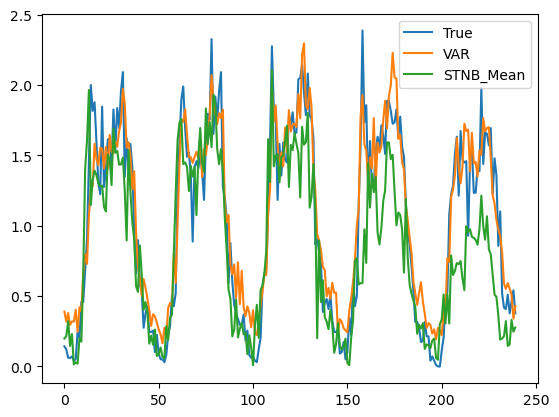

In [43]:
plt.plot(o_demand_test.mean(0),label='True')
plt.plot(o_var_pred.mean(0),label='VAR')
plt.plot(pred_stnb.mean(0),label='STNB_Mean')
plt.legend()

In [44]:
print_errors(o_demand_test,o_pred_ha,'HA_30min')
print_errors(o_demand_test,o_var_pred.astype(np.int8),'VAR_30min')
print_errors(o_demand_test,lstm_pred.T,'LSTM_30min')
print_errors(o_demand_test,pred_stnb,'STNB_30min')

HA_30min  RMSE 1.7947 MAE 0.8890 R2 0.2661 KL-Div: 54569.2081: 
VAR_30min  RMSE 1.5692 MAE 0.7806 R2 0.4389 KL-Div: 43630.6411: 
LSTM_30min  RMSE 1.8223 MAE 0.9016 R2 0.2433 KL-Div: 41140.5871: 
STNB_30min  RMSE 1.5518 MAE 0.8151 R2 0.4513 KL-Div: 60376.9933: 


In [45]:
# Save predictions
np.save('../../data/02_INTERMEDIATE/Pred_HA_30mins.npy',o_pred_ha)
np.save('../../data/02_INTERMEDIATE/Pred_VAR_30mins.npy',o_var_pred.astype(np.int8))
np.save('../../data/02_INTERMEDIATE/Pred_LSTM_30mins.npy',lstm_pred.T)
np.save('../../data/02_INTERMEDIATE/Pred_STNB_30mins.npy',pred_stnb)